In [12]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 1.4 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 702.9 kB/s eta 0:00:00a 0:00:01
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 1.2 MB/s eta 0:00:00a 0:00:01


In [41]:
import gym
import numpy as np

In [85]:
env = gym.make('CartPole-v0',render_mode='rgb_array')
env.reset()
gym.version.VERSION

/Users/tangyun/opt/miniconda3/envs/rl/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


'0.26.2'

In [75]:
env.action_space,
env.observation_space # Cart Position|Cart Velocity|Pole Angle|Pole Angular Velocity

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

- action space

|Num|Action|
|-|-|
|0|Push cart to the left|
|1|Push cart to the righ|

- observation space

|Num|Observation|Min|Max|
|-|-|-|-|
|0|Cart Position|-4.8|4.8|
|1|Cart Velocity|-inf|+inf|
|2|Pole Angle|~-0.418| ~ +0.418|
|3|Pole Angular Velocity|-inf|+inf|


- 环境的定义action和state
$$
\begin{split}
\mathcal{R}(s_t,a_t) = r_t\\
\mathcal{P}(s_t,a_t) = s_{t+1}
\end{split}
$$

In [88]:
state, _ = env.reset()
steps = 0
done = False
frames = []
while not done:
    frames.append(env.render())
    action = env.action_space.sample()
    state, reward, done, _, _ = env.step(action)
    steps += 1
    print(f"step:{steps} state:{state}")

step:1 state:[ 0.03896522 -0.15079325  0.01987594  0.3118274 ]
step:2 state:[0.03594936 0.04403998 0.02611249 0.02547842]
step:3 state:[ 0.03683016  0.2387779   0.02662206 -0.2588527 ]
step:4 state:[0.04160571 0.04328622 0.02144501 0.0421069 ]
step:5 state:[ 0.04247144  0.2380942   0.02228714 -0.24373353]
step:6 state:[0.04723332 0.04266111 0.01741247 0.05589517]
step:7 state:[ 0.04808654  0.23752911  0.01853038 -0.23124354]
step:8 state:[0.05283713 0.04214735 0.01390551 0.06722642]
step:9 state:[ 0.05368007 -0.15317118  0.01525003  0.36426398]
step:10 state:[0.05061665 0.04173076 0.02253531 0.07642841]
step:11 state:[ 0.05145127 -0.15370688  0.02406388  0.37613526]
step:12 state:[0.04837713 0.04106516 0.03158659 0.09113587]
step:13 state:[ 0.04919843  0.23572047  0.0334093  -0.19141652]
step:14 state:[0.05391284 0.0401369  0.02958097 0.11161563]
step:15 state:[ 0.05471558 -0.15539616  0.03181329  0.41348246]
step:16 state:[ 0.05160765 -0.35095426  0.04008294  0.71602273]
step:17 state

/Users/tangyun/opt/miniconda3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [95]:
NUM_BINS = 6


def bins(clip_min, clip_max, num_bins=NUM_BINS):
    return np.linspace(clip_min, clip_max, num_bins+1)[1:-1]


# 将4位6进制数，映射为一个数字
def digitize_state(state):
    pos, cart_v, angle, angle_v = state
    digitized = [
        np.digitize(pos, bins=bins(-2.4, 2.4, NUM_BINS)),
        np.digitize(cart_v, bins=bins(-3., 3., NUM_BINS)),
        np.digitize(angle, bins=bins(-0.418, 0.418, NUM_BINS)),
        np.digitize(angle_v, bins=bins(-2., 2., NUM_BINS)),
    ]
    # a,b,c,d|范围都在0-6，按照6进制进行计算，a*6^0+b*6^1+c*6^2+d*6^3
    ind = sum([d*(NUM_BINS**i) for i, d in enumerate(digitized)])
    return ind

In [98]:
bins(-2.4,2.4)
np.random.rand()

0.059272239668758164

## 1. q-learning
- $Q(s_t,a_t) = Q(s_t,a_t)+\eta (R_{t+}+\gamma\max_a Q(s_{t+1},a)- Q(s_t,a_t)) $

In [122]:
class Agent:
    def __init__(self, n_states, action_space, eta=0.5, gamma=0.99, num_bins=6) -> None:
        self.eta = 0.5
        self.gamma = gamma
        self.action_space = action_space
        self.NUM_DIGITIZED = num_bins
        self.Q = np.random.uniform(0, 1, size=(
            self.NUM_DIGITIZED**n_states, self.action_space.n))

    
    # 分桶， 5个值，对应 6 个分段，即 6 个桶 (0, 1, 2, 3, 4, 5)
    @staticmethod
    def _bins(clip_min, clip_max, num_bins):
        return np.linspace(clip_min, clip_max, num_bins+1)[1:-1]

    # 按 6 进制映射将 4位 6 进制数映射为 id，
    @staticmethod
    def _digitize_state(observation, NUM_DIGITIZED):
        pos, cart_v, angle, pole_v = observation
        digitized = [np.digitize(pos, bins=Agent._bins(-2.4, 2.4, NUM_DIGITIZED)), 
                     np.digitize(cart_v, bins=Agent._bins(-3., 3, NUM_DIGITIZED)), 
                     np.digitize(angle, bins=Agent._bins(-0.418, 0.418, NUM_DIGITIZED)), 
                     np.digitize(pole_v, bins=Agent._bins(-2, 2, NUM_DIGITIZED))]
        # 3,1,2,4 (4位10进制数) = 4*10^0 + 2*10^1 + 1*10^2 + 3*10^3，最终的取值范围是 0-9999，总计 10^4 == 10000
        # a,b,c,d (4位6进制数) = d*6^0 + c*6^1 + b*6^2 + a*6^3，最终的取值范围是 0-`5555`(1295)，总计 6^4 == 1296
        ind = sum([d*(NUM_DIGITIZED**i) for i, d in enumerate(digitized)])
        return ind

    # def q_learning(self, state, action, reward, s_next):
    #     idx = digitize_state(state)
    #     next_idx = digitize_state(s_next)
    #     self.Q[idx, action] = self.Q[idx, action]+self.eta * \
    #         (reward+self.gamma*np.max(self.Q[next_idx, :])-self.Q[idx, action])
    
#     def update_q_table()
    def q_learning(self, obs, action, reward, obs_next):
        obs_ind = Agent._digitize_state(obs, self.NUM_DIGITIZED)
        obs_next_ind = Agent._digitize_state(obs_next, self.NUM_DIGITIZED)
        self.Q[obs_ind, action] = self.Q[obs_ind, action] + self.eta*(reward + max(self.Q[obs_next_ind, :]) - self.Q[obs_ind, action])
        
    def choose_action(self, state, episode):
        eps = 0.5*1/(episode + 1)
        state_ind = Agent._digitize_state(state, self.NUM_DIGITIZED)
        # epsilon greedy
        if np.random.rand() < eps:
            action = self.action_space.sample()
        else:
            action = np.argmax(self.Q[state_ind, :])
        return action

In [132]:
env = gym.make('CartPole-v0', render_mode='rgb_array')
state, _ = env.reset()
action_space = env.action_space
action_space
n_states = env.observation_space.shape[0]
agent = Agent(n_states, action_space)
max_episode = 1000
max_steps = 200
continue_success_episodes = 0
learning_finish_flag = False
frames = []
for episode in range(max_episode):
    state, _ = env.reset()
    for step in range(max_steps):
        if learning_finish_flag:
            frames.append(env.render())
        action = agent.choose_action(state, episode)
        s_next, _, done, _, _ = env.step(action)

        if done:
            if step < 150:
                reward = -1
                continue_success_episodes = 0
            else:
                reward = 1
                continue_success_episodes += 1
        else:
            reward = 0
        agent.q_learning(state, action, reward, s_next)
        if done:
            print(f"episode:{episode} finish steps:{step}")
            break
        state = s_next
    if learning_finish_flag:
        break
    if continue_success_episodes >= 2:
        learning_finish_flag = True
        print(f"continue finish step>195 more than 10 times!")

episode:0 finish steps:9
episode:1 finish steps:11
episode:2 finish steps:12
episode:3 finish steps:10
episode:4 finish steps:27
episode:5 finish steps:17
episode:6 finish steps:12
episode:7 finish steps:17
episode:8 finish steps:11
episode:9 finish steps:11
episode:10 finish steps:13
episode:11 finish steps:10
episode:12 finish steps:20
episode:13 finish steps:11
episode:14 finish steps:11
episode:15 finish steps:9
episode:16 finish steps:11
episode:17 finish steps:10
episode:18 finish steps:18
episode:19 finish steps:15
episode:20 finish steps:93
episode:21 finish steps:86
episode:22 finish steps:77
episode:23 finish steps:123
episode:24 finish steps:136
episode:25 finish steps:13
episode:26 finish steps:15
episode:27 finish steps:16
episode:28 finish steps:20
episode:30 finish steps:174
episode:31 finish steps:75
episode:32 finish steps:179
episode:33 finish steps:99
episode:34 finish steps:116
episode:35 finish steps:114
episode:36 finish steps:26
episode:37 finish steps:21
episode

In [133]:
len(frames)
frames[0].shape

(400, 600, 3)

## 3. rendering&animation


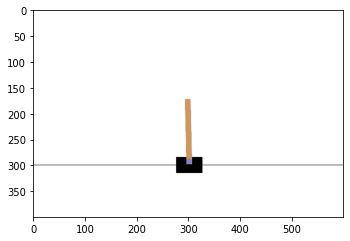

: 

In [134]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


# def display_frames_to_video(frames, name):
plt.figure(figsize=(frames[0].shape[0]/72, frames[0].shape[1]/72), dpi=72)
patch = plt.imshow(frames[0])

def animate(i):
    patch.set_data(frames[i])
anim = animation.FuncAnimation(
    plt.gcf(), animate, frames=range(len(frames)), interval=50)
anim.save(f"xx.gif")
# HTML(anim.to_jshtml())

# display_frames_to_video(frames=frames, name="xx")

/var/folders/xk/n87yv7vd6qj6v2nsxdv9q8d80000gn/T/ipykernel_49259/1326513979.py:12: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)
/var/folders/xk/n87yv7vd6qj6v2nsxdv9q8d80000gn/T/ipykernel_49259/1326513979.py:12: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)


epoch:0 total reward:17.0
epoch:1 total reward:18.0
epoch:2 total reward:28.0
epoch:3 total reward:22.0
epoch:4 total reward:13.0
